In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [34]:
import time
from itertools import chain
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad

from jax.tree_util import tree_map
import jaxlib
import jax
import pandas as pd
import optax

import jaxley as jx
from jaxley.channels import Leak
from jaxley_mech.channels.l5pc import *
from jaxley.optimize.utils import l2_norm

In [35]:
print(f"jax {jax.__version__}")
print(f"jaxlib {jaxlib.__version__}")
print(f"pandas {pd.__version__}")
print(f"optax {optax.__version__}")
print(f"numpy {np.__version__}")

jax 0.4.29
jaxlib 0.4.28
pandas 2.2.1
optax 0.2.2
numpy 1.26.4


In [36]:
def sample_within(n, bounds):
    return jnp.asarray(np.random.rand(n) * (bounds[1] - bounds[0]) + bounds[0])

In [37]:
bounds = {}
gt_apical = {}
gt_soma = {}
gt_axon = {}

bounds["apical_NaTs2T_gNaTs2T"] = [0, 0.04]
gt_apical["apical_NaTs2T_gNaTs2T"] = 0.026145

bounds["apical_SKv3_1_gSKv3_1"] = [0, 0.04]
gt_apical["apical_SKv3_1_gSKv3_1"] = 0.004226

bounds["apical_M_gM"] = [0, 0.001]
gt_apical["apical_M_gM"] = 0.000143

bounds["somatic_NaTs2T_gNaTs2T"] = [0.0, 1.0]
gt_soma["somatic_NaTs2T_gNaTs2T"] = 0.983955

bounds["somatic_SKv3_1_gSKv3_1"] = [0.25, 1]
gt_soma["somatic_SKv3_1_gSKv3_1"] = 0.303472

bounds["somatic_SKE2_gSKE2"] = [0, 0.1]
gt_soma["somatic_SKE2_gSKE2"] = 0.008407

bounds["somatic_CaPump_gamma"] = [0.0005,0.01]
gt_soma["somatic_CaPump_gamma"] = 0.000609

bounds["somatic_CaPump_decay"] = [20, 1_000]
gt_soma["somatic_CaPump_decay"] = 210.485291

bounds["somatic_CaHVA_gCaHVA"] = [0, 0.001]
gt_soma["somatic_CaHVA_gCaHVA"] = 0.000994

bounds["somatic_CaLVA_gCaLVA"] = [0, 0.01]
gt_soma["somatic_CaLVA_gCaLVA"] = 0.000333

bounds["axonal_NaTaT_gNaTaT"] = [0.0, 4.0]
gt_axon["axonal_NaTaT_gNaTaT"] = 3.137968

bounds["axonal_KPst_gKPst"] = [0.0, 1.0]
gt_axon["axonal_KPst_gKPst"] = 0.973538

bounds["axonal_KTst_gKTst"] = [0.0, 0.1]
gt_axon["axonal_KTst_gKTst"] = 0.089259

bounds["axonal_SKE2_gSKE2"] = [0.0, 0.1]
gt_axon["axonal_SKE2_gSKE2"] = 0.007104

bounds["axonal_SKv3_1_gSKv3_1"] = [0.0, 2.0]  # [0, 2.0]
gt_axon["axonal_SKv3_1_gSKv3_1"] = 1.021945

bounds["axonal_CaHVA_gCaHVA"] = [0, 0.001]  # 0.001
gt_axon["axonal_CaHVA_gCaHVA"] = 0.00099

bounds["axonal_CaLVA_gCaLVA"] = [0, 0.01]  # 0.01
gt_axon["axonal_CaLVA_gCaLVA"] = 0.008752

bounds["axonal_CaPump_gamma"] = [0.0005, 0.05]  # [0.0005,0.05]
gt_axon["axonal_CaPump_gamma"] = 0.00291

bounds["axonal_CaPump_decay"] = [20, 1_000]
gt_axon["axonal_CaPump_decay"] = 287.19873

In [38]:
nseg = 4
cell = jx.read_swc("../morphologies/bbp_with_axon.swc", nseg=nseg, max_branch_len=300.0, assign_groups=True)

soma_inds = np.unique(cell.group_nodes["soma"].branch_index).tolist()
apical_inds = np.unique(cell.group_nodes["apical"].branch_index).tolist()
basal_inds = np.unique(cell.group_nodes["basal"].branch_index).tolist()
axon_inds = np.unique(cell.group_nodes["axon"].branch_index).tolist()

########## APICAL ##########
cell.apical.set("capacitance", 2.0)
cell.apical.insert(NaTs2T().change_name("apical_NaTs2T"))
cell.apical.insert(SKv3_1().change_name("apical_SKv3_1"))
cell.apical.insert(M().change_name("apical_M"))
cell.apical.insert(H().change_name("apical_H"))
for b in apical_inds:
    for c in [0.125, 0.375, 0.625, 0.875]:
        distance = cell.branch(b).loc(c).distance(cell.branch(0).loc(0.0))
        cond = (-0.8696 + 2.087* np.exp(distance*0.0031)) * 8e-5
        cell.branch(b).loc(c).set("apical_H_gH", cond)

########## SOMA ##########
cell.soma.insert(NaTs2T().change_name("somatic_NaTs2T"))
cell.soma.insert(SKv3_1().change_name("somatic_SKv3_1"))
cell.soma.insert(SKE2().change_name("somatic_SKE2"))
ca_dynamics = CaNernstReversal()
ca_dynamics.channel_constants["T"] = 307.15
cell.soma.insert(ca_dynamics)
cell.soma.insert(CaPump().change_name("somatic_CaPump"))
cell.soma.insert(CaHVA().change_name("somatic_CaHVA"))
cell.soma.insert(CaLVA().change_name("somatic_CaLVA"))
cell.soma.set("CaCon_i", 5e-05)
cell.soma.set("CaCon_e", 2.0)

########## BASAL ##########
cell.basal.insert(H().change_name("basal_H"))
cell.basal.set("basal_H_gH", 8e-5)

# ########## AXON ##########
cell.insert(CaNernstReversal())
cell.set("CaCon_i", 5e-05)
cell.set("CaCon_e", 2.0)

cell.axon.insert(NaTaT().change_name("axonal_NaTaT"))
cell.axon.set("axonal_NaTaT_gNaTaT", 3.137968)

cell.axon.insert(KTst().change_name("axonal_KTst"))
cell.axon.set("axonal_KTst_gKTst", 0.089259)

cell.axon.insert(CaPump().change_name("axonal_CaPump"))
cell.axon.set("axonal_CaPump_gamma", 0.00291)
cell.axon.set("axonal_CaPump_decay", 287.19873)

cell.axon.insert(SKE2().change_name("axonal_SKE2"))
cell.axon.set("axonal_SKE2_gSKE2", 0.007104)

cell.axon.insert(CaHVA().change_name("axonal_CaHVA"))
cell.axon.set("axonal_CaHVA_gCaHVA", 0.00099)

cell.axon.insert(KPst().change_name("axonal_KPst"))
cell.axon.set("axonal_KPst_gKPst", 0.973538)

cell.axon.insert(SKv3_1().change_name("axonal_SKv3_1"))
cell.axon.set("axonal_SKv3_1_gSKv3_1", 1.021945)

cell.axon.insert(CaLVA().change_name("axonal_CaLVA"))
cell.axon.set("axonal_CaLVA_gCaLVA", 0.008752)


########## WHOLE CELL  ##########
cell.insert(Leak())
cell.set("Leak_gLeak", 3e-05)
cell.set("Leak_eLeak", -75.0)

cell.set("axial_resistivity", 100.0)
cell.set("eNa", 50.0)
cell.set("eK", -85.0)
cell.set("v", -65.0)

In [39]:
print(f"Number of branches: {cell.total_nbranches}")

Number of branches: 339


In [40]:
for key in gt_apical.keys():
    cell.apical.set(key, gt_apical[key])

for key in gt_soma.keys():
    cell.soma.set(key, gt_soma[key])

for key in gt_axon.keys():
    cell.axon.set(key, gt_axon[key])

In [41]:
def set_all_branches(params):
    """
    Args:
        params: Should have shape `(10,)`.
    """
    counter = 0
    pstate = None

    # Apical.
    for key in gt_apical.keys():
        pstate = cell.apical.data_set(key, params[counter], pstate)
        counter += 1
    
    # Soma.
    for key in gt_soma.keys():
        pstate = cell.soma.data_set(key, params[counter], pstate)
        counter += 1

    # Axon.
    for key in gt_axon.keys():
        pstate = cell.axon.data_set(key, params[counter], pstate)
        counter += 1

    assert counter == 19
    return pstate

In [42]:
dt = 0.025
t_max = 100.0
time_vec = np.arange(0, t_max+2*dt, dt)

cell.delete_stimuli()
cell.delete_recordings()

i_delay = 10.0
i_dur = 80.0
i_amp = 3.0
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
cell.branch(soma_inds[0]).loc(0.0).stimulate(current)  # Stimulate soma
cell.branch(soma_inds[0]).loc(0.0).record()

cell.set("v", -65.0)
cell.init_states()

Added 1 external_states. See `.externals` for details.
Added 1 recordings. See `.recordings` for details.


In [43]:
num_cp = 2
cp = [int(np.ceil((100 * 40)**(1/num_cp))) for _ in range(num_cp)]

In [44]:
def simulate(params):
    parameters = set_all_branches(params)
    return jx.integrate(cell, param_state=parameters, checkpoint_lengths=cp)

jitted_sim = jit(simulate)
vmapped_sim = jit(vmap(simulate, in_axes=(0,)))

def sim_gt():
    return jx.integrate(cell)

jitted_sim_gt = jit(sim_gt)

In [45]:
x_o = jitted_sim_gt()

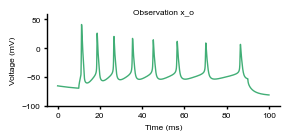

In [46]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 1.2))
    _ = ax.plot(time_vec, x_o.T, c="#41ae76")
    _ = ax.set_ylim([-100, 60])
    _ = ax.set_title(f"Observation x_o", y=0.9)
    _ = ax.set_xlabel("Time (ms)")
    _ = ax.set_ylabel("Voltage (mV)")
    # plt.savefig("results/figs/observation.png", dpi=300, bbox_inches="tight")
    plt.show()

In [47]:
def summary_stats(v):
    losses = np.zeros((len(v)))
    summstats = []
    for window in windows:
        mean_x = np.mean(v[:, window], axis=1)[0]
        std_x = np.std(v[:, window], axis=1)[0]
        summstats.append(mean_x)
        summstats.append(std_x)
    
    return jnp.asarray(summstats).T

vmapped_summary_stats = vmap(summary_stats, in_axes=(0,))


def loss_from_v(v):
    ss = summary_stats(v)
    return jnp.sum(jnp.abs((ss - x_o_ss) / z_score_factors), axis=0)


vmapped_loss_from_v = vmap(loss_from_v, in_axes=(0,))

# Random search

In [48]:
nbatches = 100
n_per_batch = 100
_ = np.random.seed(1)

batches = []
for batch in range(nbatches):
    param_batch = []
    for i in range(n_per_batch):
        param_set = []
        for key in bounds:
            param_set.append(sample_within(1, bounds[key]).tolist())
        param_set = list(chain(*param_set))
        param_batch.append(param_set)
    batches.append(param_batch)
batches = jnp.asarray(batches)

In [49]:
v = vmapped_sim(jnp.asarray(batches[0]))

In [50]:
start_time = time.time()
vs = []
for batch in batches:
    v = vmapped_sim(jnp.asarray(batch))
    print("Finished batch")
    vs.append(v)
vs = jnp.concatenate(vs, axis=0)
random_search_total_time = time.time() - start_time
print("Time", random_search_total_time)

Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished batch
Finished b

In [59]:
# with open("../results/01_synthetic/random_search_total_time.pkl", "wb") as handle:
#     pickle.dump(random_search_total_time, handle)

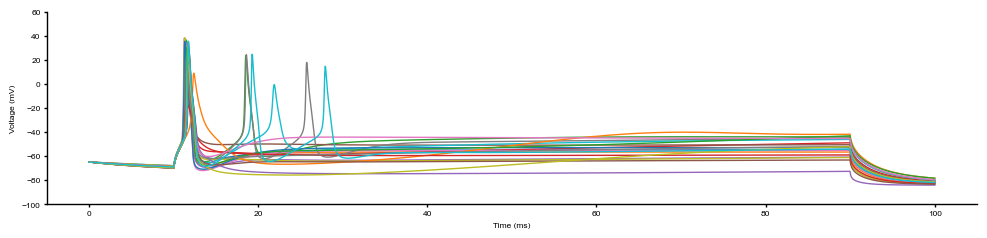

In [60]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(12, 2.5))
    _ = ax.plot(time_vec, vs[:20, 0, :].T)
    _ = ax.set_xlabel("Time (ms)")
    _ = ax.set_ylabel("Voltage (mV)")
    _ = ax.set_ylim([-100, 60])
    plt.show()

In [61]:
windows = [np.arange(200,2200), np.arange(2200,3800)]
z_score_factors = jnp.asarray([8.0, 4.0, 8.0, 4.0])
# x_o = observations[5]
x_o_ss = summary_stats(x_o)

In [62]:
losses = vmapped_loss_from_v(vs)
inds = np.argsort(losses)
num_vis = 5
best_vs = vs[inds[:num_vis]]

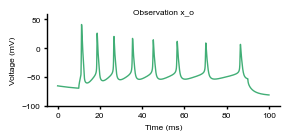

In [63]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 1.2))
    _ = ax.plot(time_vec, x_o.T, c="#41ae76")
    _ = ax.set_ylim([-100, 60])
    _ = ax.set_title(f"Observation x_o", y=0.9)
    _ = ax.set_xlabel("Time (ms)")
    _ = ax.set_ylabel("Voltage (mV)")
    # plt.savefig("results/figs/observation.png", dpi=300, bbox_inches="tight")
    plt.show()

In [119]:
l = losses[:10000]
print("np.sort(l)[:10]", np.sort(l)[:20])

np.sort(l)[:10] [0.26814801 0.27830103 0.41764609 0.47953672 0.51545574 0.55601058
 0.55916646 0.57597647 0.64497247 0.65361051 0.68581505 0.68876364
 0.70468663 0.72798089 0.73070699 0.75429911 0.75823741 0.76201877
 0.76959555 0.7836841 ]


In [117]:
print("Random search number of required simulations", len(losses) / np.sum(losses < 0.55))

Random search number of required simulations 2000.0


In [ ]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(num_vis, 1, figsize=(3, 6))
    for i in range(num_vis):
        _ = ax[i].plot(time_vec, best_vs[i, 0, :].T, c="k")
        _ = ax[i].set_ylim([-100, 60])
        _ = ax[i].set_title(f"Loss {losses[inds][i]:.5f}", y=0.75)
    for i in range(num_vis-1):
        _ = ax[i].set_xticklabels([])
    _ = ax[-1].set_xlabel("Time (ms)")
    _ = ax[2].set_ylabel("Voltage (mV)")
    # plt.savefig("results/figs/prior_predictives.png", dpi=300, bbox_inches="tight")
    plt.show()

# Gradient descent

In [26]:
def loss_fn(opt_params):
    params = transform.forward(opt_params)
    vals = [list(p.values())[0] for p in params]
    vs = simulate(vals)
    loss = loss_from_v(vs)
    return loss

jitted_loss_fn = jit(loss_fn)
grad_fn = jit(value_and_grad(loss_fn))

In [27]:
def init():
    param_set = []
    for key in bounds:
        param_set.append({key: jnp.asarray(sample_within(1, bounds[key]))})
    return param_set

In [28]:
transform = jx.ParamTransform(
    lowers={
        "apical_NaTs2T_gNaTs2T": 0.0,
        "apical_SKv3_1_gSKv3_1": 0.0,
        "apical_M_gM": 0.0,
        "somatic_NaTs2T_gNaTs2T": 0.0,
        "somatic_NaTs2T_gNaTs2T": 0.0,
        "somatic_SKv3_1_gSKv3_1": 0.25,
        "somatic_SKE2_gSKE2": 0.0,
        "somatic_CaPump_gamma": 0.0005,
        "somatic_CaPump_decay": 20.0,
        "somatic_CaHVA_gCaHVA": 0.0,
        "somatic_CaLVA_gCaLVA": 0.0,
        "axonal_NaTaT_gNaTaT": 0.0,
        "axonal_KPst_gKPst": 0.0,
        "axonal_KTst_gKTst": 0.0,
        "axonal_SKE2_gSKE2": 0.0,
        "axonal_SKv3_1_gSKv3_1": 0.0,
        "axonal_CaHVA_gCaHVA": 0,
        "axonal_CaLVA_gCaLVA": 0,
        "axonal_CaPump_gamma": 0.0005,
        "axonal_CaPump_decay": 20,
    },
    uppers={
        "apical_NaTs2T_gNaTs2T": 0.04,
        "apical_SKv3_1_gSKv3_1": 0.04,
        "apical_M_gM": 0.001,
        "somatic_NaTs2T_gNaTs2T": 1.0,
        "somatic_NaTs2T_gNaTs2T": 1.0,
        "somatic_SKv3_1_gSKv3_1": 1.0,
        "somatic_SKE2_gSKE2": 0.1,
        "somatic_CaPump_gamma": 0.01,
        "somatic_CaPump_decay": 1000.0,
        "somatic_CaHVA_gCaHVA": 0.001,
        "somatic_CaLVA_gCaLVA": 0.01,
        "axonal_NaTaT_gNaTaT": 4.0,
        "axonal_KPst_gKPst": 1.0,
        "axonal_KTst_gKTst": 0.1,
        "axonal_SKE2_gSKE2": 0.1,
        "axonal_SKv3_1_gSKv3_1": 2.0,
        "axonal_CaHVA_gCaHVA": 0.001,
        "axonal_CaLVA_gCaLVA": 0.01,
        "axonal_CaPump_gamma": 0.05,
        "axonal_CaPump_decay": 1_000,
    },
)

In [29]:
start_time = time.time()
set = init()
opt_params = transform.inverse(set)
jitted_loss_fn(opt_params)
print("Time", time.time() - start_time)

Time 29.791383981704712


In [30]:
start_time = time.time()
loss_val, grad_val = grad_fn(opt_params)
print("Time", time.time() - start_time)

Time 191.37147188186646


In [31]:
from copy import deepcopy

In [37]:
_ = np.random.seed(0)

losses_of_every_starting_point = []
best_traces = []
best_losses = []
all_best_params = []
total_sims = 0
# beta=0 -> gradient descent
# 0<beta<1 -> gradient is not fully normalized, but tends to be more equally long
# beta=1 -> GD where the gradient is normalized to unit lenght
# beta>1 -> larger gradients lead to smaller stepsizes
beta = 0.8

start_time = time.time()
for seed in np.arange(42, 42+10):
    np.random.seed(seed)
    initial_params = init()
    opt_params = transform.inverse(initial_params)
    
    train_losses = []
    
    best_loss = 100.0
    required_loss = 0.9

    optimizer = optax.inject_hyperparams(optax.sgd)(learning_rate=3.0)
    opt_state = optimizer.init(opt_params)
    for epoch in range(10):
        loss_val, grad_val = grad_fn(opt_params)
        total_sims += 1

        grad_norm = l2_norm(grad_val)
        grad_val = tree_map(lambda x: x / grad_norm**beta, grad_val) 
        print(f"loss in epoch {epoch}: {loss_val:.4f}, gradient_norm {grad_norm:.4f}, corrected {l2_norm(grad_val):.4f}")
        train_losses.append(loss_val)

        # Convergence checks.
        if loss_val < best_loss:
            best_loss = loss_val
            best_params = deepcopy(opt_params)

        # Optimizer step.
        opt_state.hyperparams['learning_rate'] = loss_val / 3.0  # Polyak style learning rate.
        updates, opt_state = optimizer.update(grad_val, opt_state)
        update_norm = l2_norm(updates)
        opt_params = optax.apply_updates(opt_params, updates)

    params = transform.forward(best_params)
    vals = [list(p.values())[0] for p in params]
    best_trace = jitted_sim(vals)

    if best_loss < 1.0:
        best_traces.append(best_trace)
        best_losses.append(best_loss)
        all_best_params.append(best_params)
    print(f"Seed {seed} ===== Best loss {best_loss}")
    losses_of_every_starting_point.append(train_losses)

gradient_descent_total_time = time.time() - start_time
print("gradient_descent_total_time", gradient_descent_total_time)

loss in epoch 0: 3.5467, gradient_norm 1.1580, corrected 1.0298
loss in epoch 1: 3.2589, gradient_norm 2.5861, corrected 1.2093
loss in epoch 2: 3.1090, gradient_norm 2.6798, corrected 1.2179
loss in epoch 3: 2.2034, gradient_norm 3.3634, corrected 1.2745
loss in epoch 4: 0.7987, gradient_norm 1.1870, corrected 1.0349
loss in epoch 5: 0.7359, gradient_norm 3.1416, corrected 1.2573
loss in epoch 6: 0.7463, gradient_norm 2.9230, corrected 1.2393
loss in epoch 7: 0.6432, gradient_norm 2.1527, corrected 1.1657
loss in epoch 8: 0.6114, gradient_norm 0.8181, corrected 0.9606
loss in epoch 9: 0.5259, gradient_norm 0.3574, corrected 0.8140
Seed 42 ===== Best loss 0.5259327437730188
loss in epoch 0: 5.3761, gradient_norm 2.9342, corrected 1.2402
loss in epoch 1: 3.7797, gradient_norm 2.8815, corrected 1.2357
loss in epoch 2: 1.2715, gradient_norm 0.4852, corrected 0.8653
loss in epoch 3: 0.8791, gradient_norm 9.2036, corrected 1.5588
loss in epoch 4: 0.5089, gradient_norm 0.5973, corrected 0.90

In [34]:
# with open("../results/01_synthetic/gradient_descent_total_time.pkl", "wb") as handle:
#     pickle.dump(gradient_descent_total_time, handle)

In [35]:
with open("../results/01_synthetic/all_best_params.pkl", "wb") as handle:
    pickle.dump(all_best_params, handle)
with open("../results/01_synthetic/best_traces.pkl", "wb") as handle:
    pickle.dump(best_traces, handle)
with open("../results/01_synthetic/best_losses.pkl", "wb") as handle:
    pickle.dump(best_losses, handle)
with open("../results/01_synthetic/total_sims.pkl", "wb") as handle:
    pickle.dump(total_sims, handle)
with open("../results/01_synthetic/x_o.pkl", "wb") as handle:
    pickle.dump(x_o, handle)
with open("../results/01_synthetic/time_vec.pkl", "wb") as handle:
    pickle.dump(time_vec, handle)
with open("../results/01_synthetic/losses_of_every_starting_point.pkl", "wb") as handle:
    pickle.dump(losses_of_every_starting_point, handle)


# Genetic algorithm

In [43]:
import bluepyopt as bpopt
from bluepyopt.parameters import Parameter


class HHEvaluator(bpopt.evaluators.Evaluator):
    def __init__(self, x_labels, params):
        super().__init__(objectives=x_labels, params=params)

    def init_simulator_and_evaluate_with_lists(self, param_list):
        global ga_losses
        param_list = jnp.asarray(param_list)
        vs = vmapped_sim(param_list)
        losses = vmapped_loss_from_v(vs)[:, None].tolist()
        print(f"Minimal loss {np.min(losses)}")
        ga_losses.append(np.min(losses).item())
        return losses


def map_fun(evaluate_with_lists, list_of_thetas):
    results = evaluate_with_lists(list_of_thetas)
    return results


x_labels = ["loss"]

params = []
for key in bounds:
    params.append(Parameter(f"{key}", bounds=bounds[key]))

all_ga_losses = []
start_time = time.time()
for seed in range(0, 10):
    ga_losses = []
    print("seed", seed)
    evaluator = HHEvaluator(x_labels, params)
    opt = bpopt.deapext.optimisations.IBEADEAPOptimisation(
        evaluator,
        offspring_size=10,
        map_function=map_fun,
        seed=seed,
        eta=10,
        mutpb=1.0,
        cxpb=1.0,
    )
    final_pop, halloffame, log, hist = opt.run(max_ngen=10)
    all_ga_losses.append(deepcopy(ga_losses))

genetic_algorithm_total_time = time.time() - start_time
print("genetic_algorithm_total_time", genetic_algorithm_total_time)

seed 0
Minimal loss 3.736570226485152
Minimal loss 3.8538670147553207
Minimal loss 1.5439948268914439
Minimal loss 1.0220264454701682
Minimal loss 1.245753770505737
Minimal loss 1.139387816292536
Minimal loss 0.7979264515984563
Minimal loss 0.6626621195127864
Minimal loss 0.9706227900999465
Minimal loss 0.739932318535141
seed 1
Minimal loss 2.15450836011129
Minimal loss 1.2764281582635513
Minimal loss 1.1602206719069819
Minimal loss 0.9718225997644012
Minimal loss 0.8673910099734083
Minimal loss 0.8152918228440047
Minimal loss 0.5744453946620842
Minimal loss 0.7449465513570166
Minimal loss 0.621135053485764
Minimal loss 0.4427928587787755
seed 2
Minimal loss 1.2995755690954618
Minimal loss 2.622979305784492
Minimal loss 1.1529226167245255
Minimal loss 1.0692335085047837
Minimal loss 0.9042809251463266
Minimal loss 0.6905646728296646
Minimal loss 0.8214445243718203
Minimal loss 0.6719806198925586
Minimal loss 0.6919875321431315
Minimal loss 0.5959104600687732
seed 3
Minimal loss 4.14455

In [44]:
with open("../results/01_synthetic/genetic_algorithm_total_time.pkl", "wb") as handle:
    pickle.dump(genetic_algorithm_total_time, handle)
with open("../results/01_synthetic/genetic_algorithm_losses.pkl", "wb") as handle:
    pickle.dump(all_ga_losses, handle)